# Import Library

In [1]:
from google.colab import userdata

import ast
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Memuat Dataset

In [2]:
# Ambil kredensial dari Google Colab Secrets
kaggle_username = userdata.get('kaggle_username')  # Nama pengguna
kaggle_key = userdata.get('kaggle_key')     # Kunci API

# Set variabel lingkungan untuk Kaggle
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

In [3]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
 76% 19.0M/25.0M [00:00<00:00, 199MB/s]
100% 25.0M/25.0M [00:00<00:00, 175MB/s]


In [4]:
!unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [5]:
df_anime = pd.read_csv('anime.csv')

In [6]:
df_rating = pd.read_csv('rating.csv')

# Exploratory Data Analysis (EDA)

## Anime Variabel

Menampilkan Isi dan Struktur Dataset Anime

In [7]:
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


<ipython-input-9-8daf4961af9c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_genres, x='Genre', y='Count', palette='viridis')


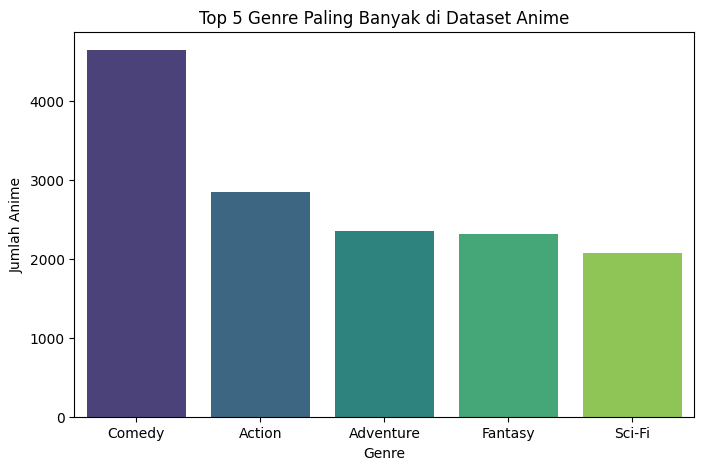

In [9]:
all_genres = df_anime['genre'].dropna().str.split(', ')
flat_genres = [genre for sublist in all_genres for genre in sublist]
genre_counts = Counter(flat_genres)
top5_genres = genre_counts.most_common(5)

df_top_genres = pd.DataFrame(top5_genres, columns=['Genre', 'Count'])

plt.figure(figsize=(8,5))
sns.barplot(data=df_top_genres, x='Genre', y='Count', palette='viridis')
plt.title('Top 5 Genre Paling Banyak di Dataset Anime')
plt.ylabel('Jumlah Anime')
plt.xlabel('Genre')
plt.show()

Insight : Dari output ini, kita dapat melihat seberapa lengkap data dan menilai kualitas dataset anime untuk analisis lebih lanjut seperti pembuatan sistem rekomendasi anime. Kemudian pada visualisasi terdapat genre terbanyak pada dataset ini. Genre Comedy menjadi genre paling banyak.

## Rating Variabel

Menampilkan Isi dan Struktur Dataset Rating

In [10]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [11]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [12]:
df_rating = df_rating[df_rating.user_id <= 10000]

In [13]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1042697 entries, 0 to 1042696
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1042697 non-null  int64
 1   anime_id  1042697 non-null  int64
 2   rating    1042697 non-null  int64
dtypes: int64(3)
memory usage: 31.8 MB


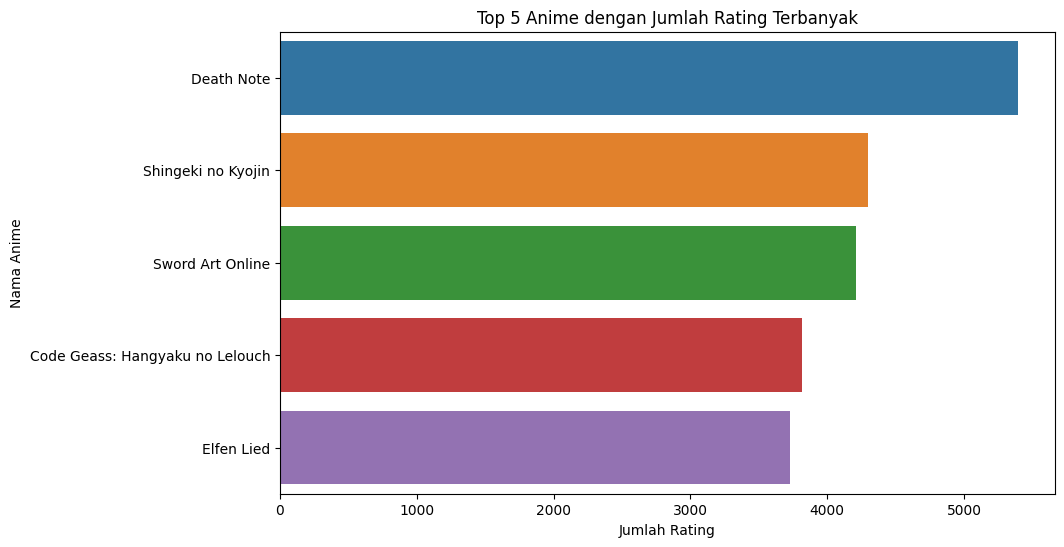

In [14]:
rating_counts = df_rating['anime_id'].value_counts().head(5)

top5_rated_anime = pd.DataFrame({
    'anime_id': rating_counts.index,
    'rating_count': rating_counts.values
}).merge(df_anime[['anime_id', 'name']], on='anime_id')

plt.figure(figsize=(10,6))
sns.barplot(data=top5_rated_anime, x='rating_count', y='name', hue='name', dodge=False, legend=False)
plt.title('Top 5 Anime dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Nama Anime')
plt.show()

Insight : Dari output ini, kita dapat melihat seberapa lengkap data dan menilai kualitas dataset rating untuk analisis lebih lanjut seperti pembuatan sistem rekomendasi anime. Kode `df_rating = df_rating[df_rating.user_id <= 10000]` digunakan untuk mengambil user_id di bawah 10000. Hal ini agar pada proses rekomendasi tidak terlalu banyak mengambil data. Lalu pada visualisasi Anime `Death Note` menjadi rating terbanyak.

# Data Preparation

## Mengatasi Rating Tidak Valid

Membersihkan nilai rating tidak valid pada dataset rating

In [15]:
df_rating['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2])

In [16]:
df_rating['rating'] = df_rating['rating'].replace(-1, pd.NA)

Insight :
- `df_rating['rating'].unique()` digunakan untuk mengecek semua nilai unik yang terdapat dalam kolom rating. Ini berguna untuk menemukan adanya nilai tidak valid atau anomali, seperti -1 yang biasanya menandakan bahwa user belum memberi rating sebenarnya (misalnya hanya menonton tapi tidak menilai).

- `df_rating['rating'] = df_rating['rating'].replace(-1, pd.NA)` mengganti semua nilai -1 dengan pd.NA (missing value dalam Pandas). Ini penting agar model rekomendasi tidak menganggap -1 sebagai rating numerik yang valid. Nilai -1 berarti pengguna menonton tetapi tidak menilai anime tersebut.

## Mengatasi Missing Value

Membersihkan nilai kosong pada dataset anime dan rating

In [17]:
df_anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [18]:
df_anime.dropna(inplace=True)

In [19]:
df_rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,193533


Insight :
- Pada dataset anime, terdapat nilai null pada kolom genre, type, dan rating. Karena tidak jumlah null masih tergolong sedikkit, jadi diputuskan untuk menghapus nilai null tersebut.
- Pada dataset rating, terdapat banyak sekali nilai null pada kolom rating. Hal ini disebabkan pada kode sebelumnya bahwa mengganti nilai anomali (-1) menjadi NaN. Karena -1 adalah pengguna yang menonton tetapi tidak menilai, maka akan dibiarkan saja. Hal ini dibiarkan untuk nanti diproses pada modeling.

## Mengatasi Duplicated Value

Membersihkan nilai duplikat pada dataset anime dan rating

In [20]:
df_anime.duplicated().sum()

np.int64(0)

In [21]:
df_rating.duplicated().sum()

np.int64(0)

Insight : Kode tersebut digunakan untuk mendeteksi apakah ada data duplikat pada kedua dataset, yaitu `df_anime` dan `df_rating`. Fungsi `df_anime.duplicated().sum()` dan `df_rating.duplicated().sum()` menghitung jumlah baris yang terdeteksi sebagai duplikat dalam masing-masing dataframe. Hasil dari kedua perintah tersebut adalah `np.int64(0)`, yang berarti **tidak ada baris duplikat** yang ditemukan dalam kedua dataset. Ini menunjukkan bahwa data yang digunakan sudah bersih dari duplikasi, sehingga tidak perlu dilakukan penghapusan duplikat. Hal ini penting karena data duplikat dapat menyebabkan bias dalam perhitungan rekomendasi, terutama jika rating yang sama dihitung lebih dari sekali.


# Model Development

## Content Based Filtering



### Count Vectorizer

Meng-ektraksi fitur genre menggunakan CountVectorizer

In [22]:
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
genre_matrix = vectorizer.fit_transform(df_anime['genre']).toarray()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Insight : Kode tersebut digunakan untuk membangun matriks kesamaan (similarity matrix) antar anime berdasarkan genre yang mereka miliki. Pertama, `CountVectorizer` digunakan dengan `tokenizer=lambda x: x.split(', ')`, yang berarti genre pada setiap anime akan dipisahkan berdasarkan koma. Misalnya, genre "Action, Adventure, Comedy" akan diubah menjadi tiga token: "Action", "Adventure", dan "Comedy". Hasil transformasi ini adalah sebuah `genre_matrix` berupa array numerik biner yang menunjukkan keberadaan suatu genre pada setiap anime.

### Cosine Similarity

Menghitung kemiripan antara anime berdasarkan genre dengan Cosine Similarity

In [23]:
anime_similarity = cosine_similarity(genre_matrix)
anime_similarity

array([[1.        , 0.18898224, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18898224, 1.        , 0.28571429, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.28571429, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

Insight : `cosine_similarity(genre_matrix)` menghitung kemiripan kosinus antar anime berdasarkan vektor genre mereka. Nilai dalam `anime_similarity` akan berada dalam rentang 0 hingga 1, di mana nilai yang lebih tinggi menunjukkan bahwa dua anime memiliki genre yang lebih mirip. Matriks ini nantinya dapat digunakan untuk sistem content-based filtering, yaitu memberikan rekomendasi anime yang mirip genre-nya dengan anime yang pernah disukai user. Proses ini sangat penting karena memungkinkan pemberian rekomendasi meskipun user belum banyak memberikan rating, cukup berdasarkan kesamaan konten.

### Mendapatkan Rekomendasi

Rekomendasi anime berdasarkan genre yang mirip

In [24]:
def recommend(anime_title):
  if anime_title not in df_anime['name'].values:
      print("Anime tidak ditemukan!")
      return

  index = df_anime[df_anime['name'] == anime_title].index[0]
  distances = sorted(list(enumerate(anime_similarity[index])), reverse=True, key=lambda x: x[1])

  print(f"Rekomendasi anime mirip dengan '{anime_title}':")
  for i in distances[1:6]:
      title = df_anime.iloc[i[0]]['name']
      genre = df_anime.iloc[i[0]]['genre']
      print(f"- {title} — Genre: {genre}")

In [25]:
recommend('Kokoro ga Sakebitagatterunda.')

Rekomendasi anime mirip dengan 'Kokoro ga Sakebitagatterunda.':
- Clannad: After Story - Mou Hitotsu no Sekai, Kyou-hen — Genre: Drama, Romance, School
- True Tears — Genre: Drama, Romance, School
- &quot;Bungaku Shoujo&quot; Memoire — Genre: Drama, Romance, School
- Kimikiss Pure Rouge — Genre: Drama, Romance, School
- Myself; Yourself — Genre: Drama, Romance, School


Insight : Fungsi `recommend()` memberikan 5 rekomendasi anime yang memiliki genre paling mirip dengan judul yang diberikan, menggunakan cosine similarity dari genre. Ini merupakan implementasi content-based filtering yang sederhana dan efektif.

## Collaborative Filtering

### User-Based

Rekomendasi anime berdasarkan kesamaan antar pengguna

In [26]:
user_item_matrix = df_rating.pivot(index='user_id', columns='anime_id', values='rating')

In [27]:
user_item_matrix_filled = user_item_matrix.fillna(0)

<ipython-input-27-9c57f7f684f0>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  user_item_matrix_filled = user_item_matrix.fillna(0)


In [28]:
user_similarity = cosine_similarity(user_item_matrix_filled)

In [29]:
def user_based_recommendations(user_id, user_item_matrix, user_similarity, n=5):
    user_scores = user_similarity[user_id - 1]

    similar_users = sorted(enumerate(user_scores), key=lambda x: x[1], reverse=True)

    recommended_anime = []

    for user, score in similar_users[1:]:
        rated_anime = user_item_matrix.loc[user_item_matrix.index[user - 1]]
        positively_rated_anime = rated_anime[rated_anime >= 6].index

        target_user_rated_anime = user_item_matrix.loc[user_id].dropna().index
        recommended_anime.extend(set(positively_rated_anime) - set(target_user_rated_anime))

        if len(recommended_anime) >= n:
            break

    return recommended_anime[:n]

Insight : Fungsi `user_based_recommendations()` memberikan rekomendasi anime untuk pengguna tertentu berdasarkan kesamaan rating dengan pengguna lain. Sistem ini membandingkan pola rating antar pengguna menggunakan cosine similarity, lalu merekomendasikan anime yang disukai oleh pengguna serupa namun belum ditonton oleh target user. Pendekatan ini cocok saat banyak pengguna memberikan rating pada berbagai anime.


### Item-Based

In [30]:
item_similarity = cosine_similarity(user_item_matrix.fillna(0).T)

<ipython-input-30-5098c16ba4a5>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  item_similarity = cosine_similarity(user_item_matrix.fillna(0).T)


In [31]:
anime_id_to_idx = {anime_id: idx for idx, anime_id in enumerate(user_item_matrix.columns)}
idx_to_anime_id = {idx: anime_id for anime_id, idx in anime_id_to_idx.items()}

Rekomendasi anime berdasarkan kesamaan antar item

In [32]:
def item_based_recommendations(user_id, user_item_matrix, item_similarity, anime_id_to_idx, idx_to_anime_id, n=5):
    positively_rated_anime = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] >= 6].index

    recommended_anime = set()
    user_rated_anime = set(user_item_matrix.loc[user_id].dropna().index)

    for anime_id in positively_rated_anime:
        if anime_id not in anime_id_to_idx:
            continue

        anime_idx = anime_id_to_idx[anime_id]
        similar_anime_scores = item_similarity[anime_idx]

        similar_anime_sorted = sorted(enumerate(similar_anime_scores), key=lambda x: x[1], reverse=True)

        for idx, score in similar_anime_sorted[1:]:
            candidate_anime_id = idx_to_anime_id[idx]
            if candidate_anime_id not in user_rated_anime:
                recommended_anime.add(candidate_anime_id)
            if len(recommended_anime) >= n:
                break
        if len(recommended_anime) >= n:
            break

    return list(recommended_anime)[:n]

Insight : Fungsi `item_based_recommendations()` menyarankan anime berdasarkan kemiripan antar anime yang disukai pengguna. Dengan menghitung cosine similarity antar kolom anime (item), sistem ini merekomendasikan anime yang mirip dengan yang sudah diberi rating positif oleh pengguna, namun belum ditonton. Pendekatan ini efektif saat data pengguna sedikit, tapi data item melimpah.


### Mendapatkan Rekomendasi

Perbandingan rekomendasi anime:  User-Based vs Item-Based

In [33]:
user_id = 15

user_recommendations = user_based_recommendations(user_id, user_item_matrix, user_similarity, n=5)

item_recommendations = item_based_recommendations(user_id, user_item_matrix, item_similarity, anime_id_to_idx, idx_to_anime_id, n=5)

In [34]:
print(f"User-Based Recommendations for User {user_id}:")
for anime_id in user_recommendations:
    anime_name = df_anime.loc[df_anime['anime_id'] == anime_id, 'name'].values[0]
    print(f"- {anime_name}")

print(f"\nItem-Based Recommendations for User {user_id}:")
for anime_id in item_recommendations:
    anime_name = df_anime.loc[df_anime['anime_id'] == anime_id, 'name'].values[0]
    print(f"- {anime_name}")

User-Based Recommendations for User 15:
- Soul Eater
- Trigun
- Hellsing
- Bishoujo Senshi Sailor Moon
- Asatte no Houkou.

Item-Based Recommendations for User 15:
- Vampire Knight
- D.Gray-man
- Vampire Knight Guilty
- Zombie-Loan Specials
- D.N.Angel


Insight : Kode ini melakukan uji coba rekomendasi anime untuk pengguna tertentu (user\_id = 15) menggunakan dua metode collaborative filtering: user-based dan item-based. Hasilnya menampilkan daftar anime yang direkomendasikan berdasarkan kemiripan antar pengguna dan kemiripan antar anime. Dengan cara ini, kita dapat membandingkan efektivitas kedua pendekatan dalam memberikan rekomendasi yang relevan bagi pengguna.


# Visualisasi

Visualisasi metrik Content Based Filtering dan Collaborative Filtering

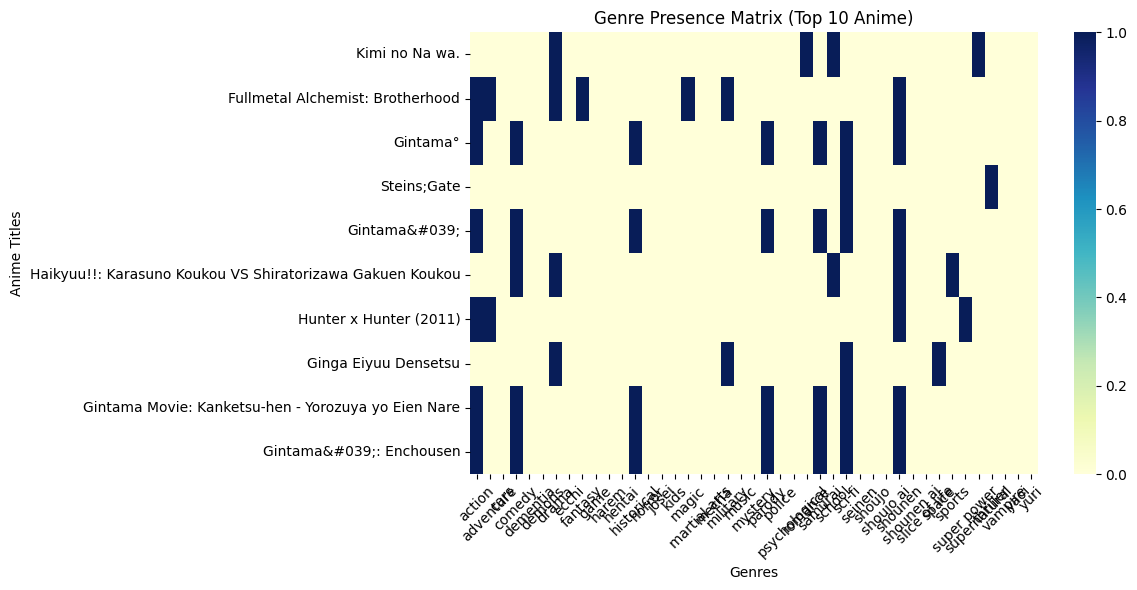

In [35]:
# Ambil subset untuk visualisasi (10 anime pertama)
genre_df = pd.DataFrame(genre_matrix[:10], columns=vectorizer.get_feature_names_out())
anime_names = df_anime['name'][:10].values

plt.figure(figsize=(12, 6))
sns.heatmap(genre_df, cmap="YlGnBu", xticklabels=True, yticklabels=anime_names)
plt.title("Genre Presence Matrix (Top 10 Anime)")
plt.xlabel("Genres")
plt.ylabel("Anime Titles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

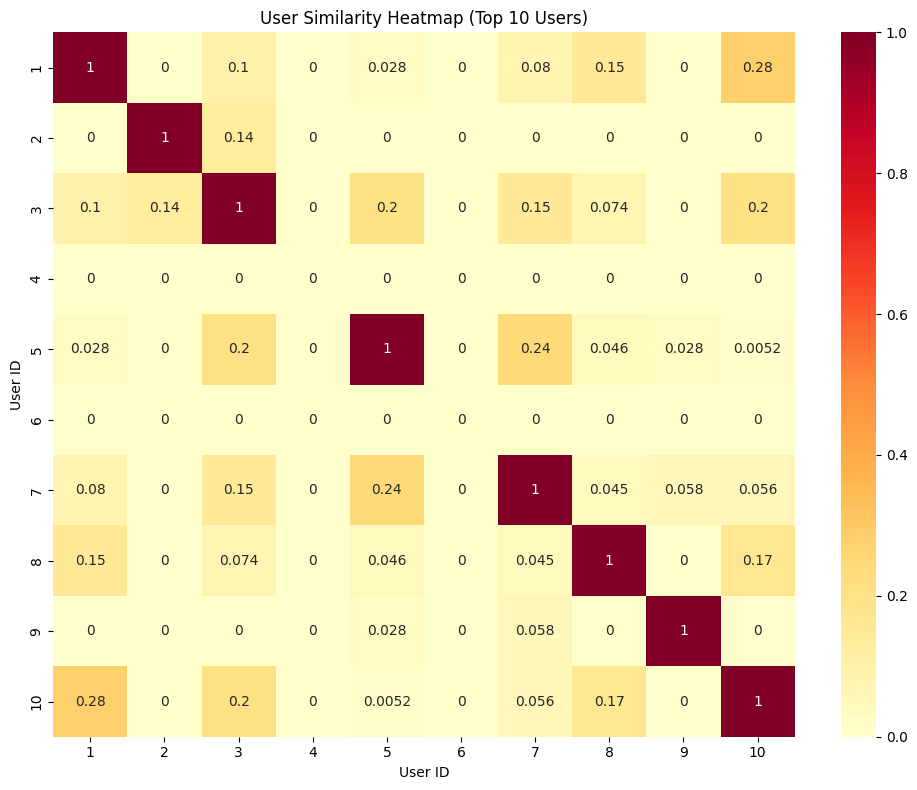

In [36]:
# Ambil subset 10 user pertama untuk visualisasi
subset_user_sim = user_similarity[:10, :10]
user_labels = user_item_matrix.index[:10]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_user_sim, annot=True, cmap="YlOrRd", xticklabels=user_labels, yticklabels=user_labels)
plt.title("User Similarity Heatmap (Top 10 Users)")
plt.xlabel("User ID")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

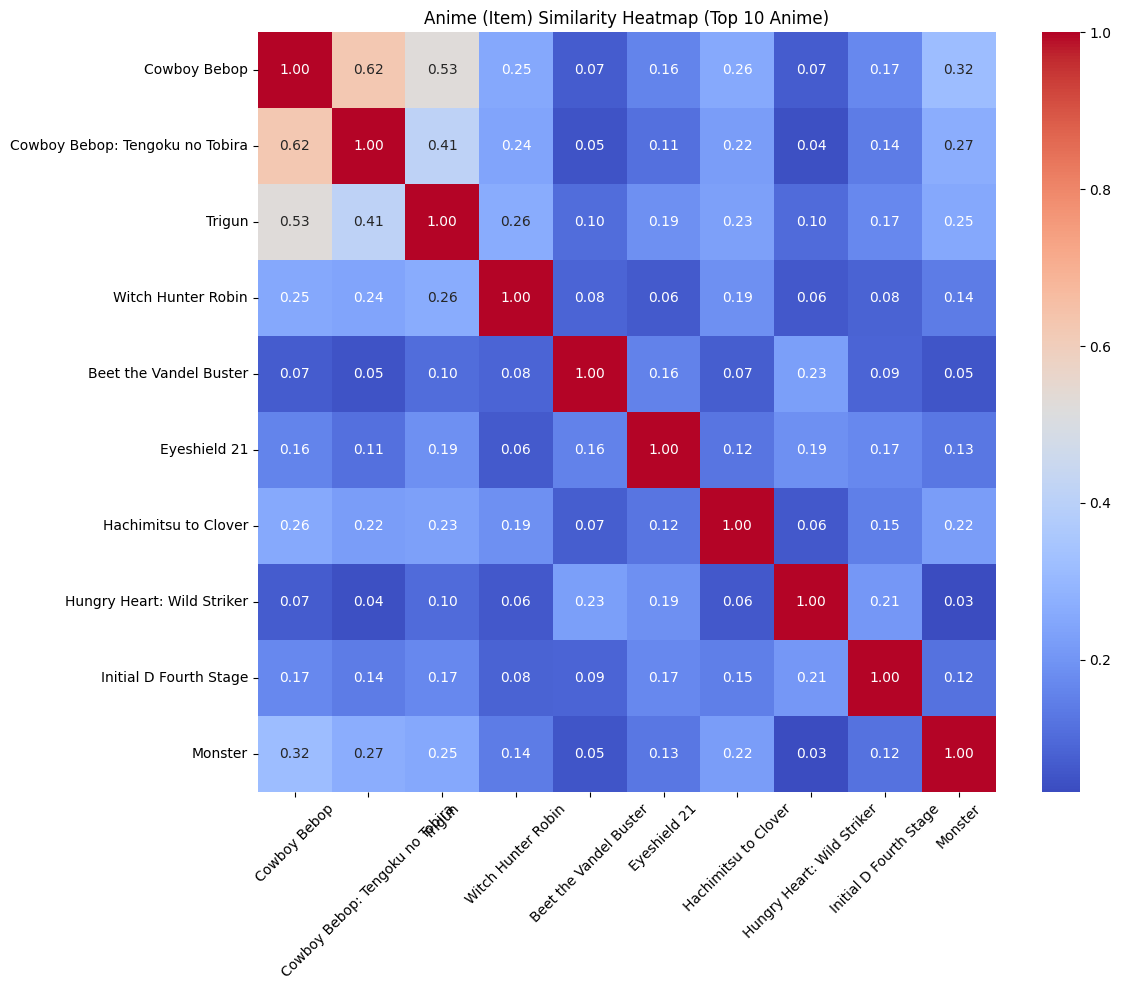

In [37]:
# Ambil subset 10 anime pertama untuk visualisasi
subset_item_sim = item_similarity[:10, :10]

# Buat label anime dari 10 anime pertama
anime_labels = [
    df_anime[df_anime['anime_id'] == idx_to_anime_id[i]]['name'].values[0]
    if idx_to_anime_id[i] in df_anime['anime_id'].values else f"ID {idx_to_anime_id[i]}"
    for i in range(10)
]

# Plot heatmap dengan angka (annot=True)
plt.figure(figsize=(12, 10))
sns.heatmap(subset_item_sim, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=anime_labels, yticklabels=anime_labels)
plt.title("Anime (Item) Similarity Heatmap (Top 10 Anime)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Insight :
- Visualisasi ini menunjukkan representasi genre dari 10 anime teratas dalam bentuk one-hot encoding (1 = memiliki genre tersebut, 0 = tidak). Dari heatmap tersebut terlihat bahwa:
  - Cowboy Bebop, Trigun, dan Cowboy Bebop: Tengoku no Tobira memiliki genre yang sama atau mirip seperti Action dan Sci-Fi. Hal ini sejalan dengan hasil heatmap similarity sebelumnya, yang menunjukkan bahwa mereka memang mirip secara item-based collaborative filtering.
  - Genre Sports muncul di anime seperti Hungry Heart: Wild Striker, Eyeshield 21, dan Initial D Fourth Stage, yang memperjelas alasan mereka saling memiliki kemiripan kecil terhadap anime bergenre action seperti Cowboy Bebop.
  - Perbedaan genre yang signifikan menjelaskan mengapa beberapa anime tidak menunjukkan kemiripan tinggi satu sama lain dalam heatmap item similarity.

- Pada kode kedua sebagian besar pengguna memiliki kemiripan yang rendah satu sama lain (nilai mendekati 0), menunjukkan bahwa preferensi mereka terhadap anime cukup beragam. Namun, terdapat beberapa pasangan pengguna dengan kemiripan yang relatif lebih tinggi (misalnya, user 1 dan user 10 = 0.28, user 3 dan user 5 = 0.2, user 5 dan user 7 = 0.24). Ini menunjukkan potensi untuk memberikan rekomendasi berbasis preferensi pengguna lain dengan tingkat kesamaan tertentu.

- Beberapa anime menunjukkan tingkat kemiripan tinggi berdasarkan pola rating pengguna, seperti:
  - Cowboy Bebop dan Cowboy Bebop: Tengoku no Tobira (similarity 0.62)
  - Cowboy Bebop dan Trigun (0.53)
  
  Ini menunjukkan bahwa pengguna yang menyukai satu anime kemungkinan besar juga akan menyukai anime yang memiliki nilai kemiripan tinggi dengannya. Heatmap ini membuktikan bahwa pendekatan Collaborative Filtering berbasis item berhasil mengidentifikasi item-item (anime) yang mirip berdasarkan preferensi kolektif pengguna, sehingga mendukung pencapaian goal kedua.